In [7]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

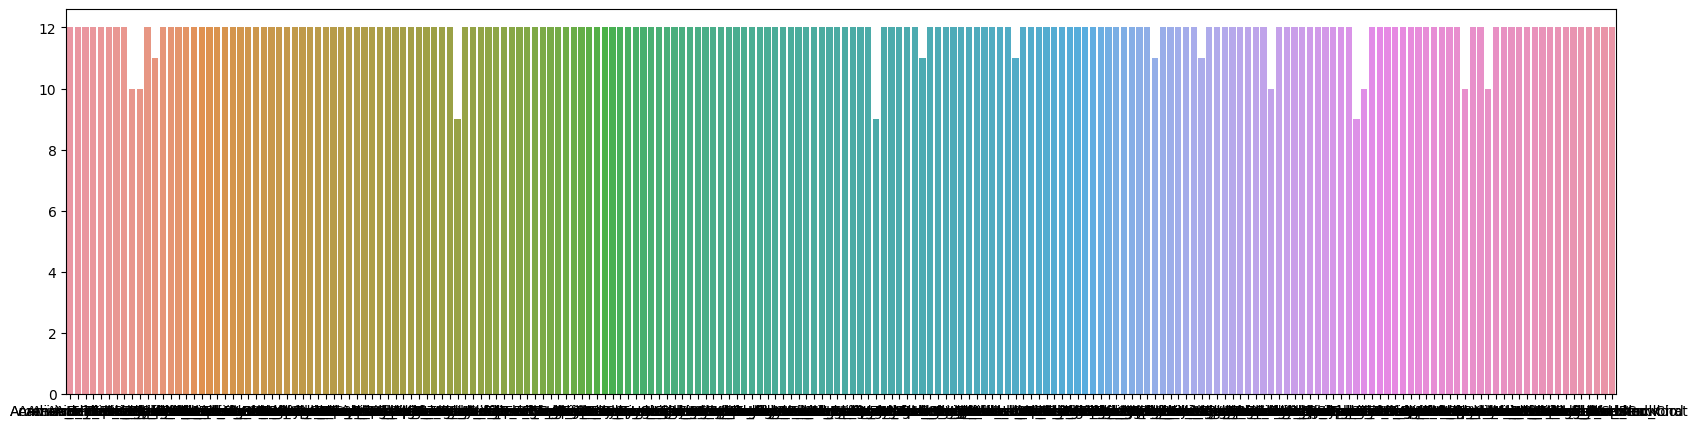

In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
SEED = 1000
IMG_SIZE = 256
BATCH_SIZE = 64

TRAIN_DIR = '/content/drive/MyDrive/Test'
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)
plt.figure(figsize=(20, 5))
sns.barplot(x=class_names, y=class_count)
plt.savefig('foo.png', dpi=1000)
plt.show()

In [9]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    seed=SEED
)
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    seed=SEED
)

Found 1777 images belonging to 200 classes.
Found 597 images belonging to 200 classes.


In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [11]:
base_model.trainable = False
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=2)

In [ ]:
resnet_model = model.fit(
    train_batch,
    epochs=20,
    steps_per_epoch=1777 // BATCH_SIZE,
    validation_data=valid_batch,
    validation_steps=597 // BATCH_SIZE,
    callbacks=[cb, reduce_lr]
)


In [ ]:
model.save("/content/drive/MyDrive/resnet_model_CTL2.h5")

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_model.history['accuracy'], label='train accuracy')
plt.plot(resnet_model.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(resnet_model.history['loss'], label='train loss')
plt.plot(resnet_model.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0, 10])
plt.legend(loc='upper right')
plt.savefig("resnet.pdf", dpi=300)
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/resnet_model.h5')

# Predict on validation data
y_pred = model.predict(valid_batch)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = valid_batch.classes

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()

In [ ]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image

In [ ]:
image_path = '/content/drive/MyDrive/Test/American_Pipit/American_Pipit_0001_100225.jpg'
preprocessed_image = preprocess_image(image_path)
preprocessed_image = np.expand_dims(preprocessed_image, axis=0)

predictions = model.predict(preprocessed_image)
class_indices = train_batch.class_indices
class_mapping = {v: k for k, v in class_indices.items()}
predicted_class_index = np.argmax(predictions)
predicted_class_name = class_mapping[predicted_class_index]
print("Predicted class:", predicted_class_name)